# Metrics and Features - Solution

In this exercise, we want to create a second label feature set. The seeded label feature set
is looking at whether a failure happens the next day. We want to evaluate the performance of the
model with a prediction farther into the future. In order to do this, we will look at whether a failure
occurs in the next week. 

To implement this, you need to do the following:
1. Define a new compound metric `WillFailNextWeek` on top of the simple metric `HasFailureEvent`.
2. Define a new feature `willFailNextWeek` on top of the compound metric.
3. Define a new feature set `labelFeatureSet2` that includes `willFailNextWeek` and has an `HOUR` interval.
4. Materialize the new feature set.
5. Use `evalFeatureSetBatch` to retrieve the materialized feature data.

Let's pick a specific subject that we'll view.

In [46]:
SUBJECT_FILTER='id=="demo_TURBINE-3"'

Review the raw data from WindTurbineEvent.

In [47]:
c3.WindTurbineEvent.eval(limit=10)

id  ... eventCode
0  00ff47ac-af70-4fe4-b124-93b54b82ebb1  ...        f1
1  0281bd6f-b0b5-4008-99d2-d109d7b84fe9  ...        f3
2  02c16276-108c-4e2c-8a12-e66248cd655a  ...        m5
3  03858e22-3a10-4e42-907e-58644d4d0e9b  ...        m3
4  03bfbe62-d4d1-45de-8393-f03428e6df6f  ...        m5
5  0551af76-32d5-46ab-a0c6-a5d367521890  ...        f1
6  06423ddc-0831-4532-abec-54e0952dc903  ...        m1
7  064705a2-97aa-4929-bd77-be112b9bf05b  ...        m5
8  06df00a8-df2b-46d9-adda-21812d82cfb6  ...        m1
9  07319187-493b-4f28-8d50-9c3a72a39bf9  ...        m5

[10 rows x 5 columns]

Now, we look at the underlying simple metric.

In [48]:
c3.WindTurbine.eval(projection='HasFailureEvent', filter=SUBJECT_FILTER)

subject  timestamp  HasFailureEvent
0    demo_TURBINE-3 2022-03-27              0.0
1    demo_TURBINE-3 2022-03-28              0.0
2    demo_TURBINE-3 2022-03-29              0.0
3    demo_TURBINE-3 2022-03-30              0.0
4    demo_TURBINE-3 2022-03-31              0.0
..              ...        ...              ...
361  demo_TURBINE-3 2023-03-23              0.0
362  demo_TURBINE-3 2023-03-24              0.0
363  demo_TURBINE-3 2023-03-25              0.0
364  demo_TURBINE-3 2023-03-26              0.0
365  demo_TURBINE-3 2023-03-27              0.0

[366 rows x 3 columns]

## Exercise step 1

Define a new compound metric called `WillFailNextWeek` that looks at `HasFailureEvent`
over 168 hours (one week). It should return true if `HasFailureEvent` is true over that time range,
and false otherwise.

In [50]:
cm = c3.CompoundMetric(
    name="WillFailNextWeek",
    id="WillFailNextWeek",
    expression="window('MAX', HasFailureEvent, 0, 168) > 0"
).upsert()
cm

{
  "type" : "CompoundMetric",
  "name" : "WillFailNextWeek",
  "expression" : "window('MAX', HasFailureEvent, 0, 168) > 0",
  "id" : "WillFailNextWeek"
}

In [49]:
c3.WindTurbine.eval(projection='WillFailNextWeek', filter=SUBJECT_FILTER)

subject  timestamp  WillFailNextWeek
0    demo_TURBINE-3 2022-03-27               1.0
1    demo_TURBINE-3 2022-03-28               1.0
2    demo_TURBINE-3 2022-03-29               1.0
3    demo_TURBINE-3 2022-03-30               1.0
4    demo_TURBINE-3 2022-03-31               1.0
..              ...        ...               ...
361  demo_TURBINE-3 2023-03-23               0.0
362  demo_TURBINE-3 2023-03-24               0.0
363  demo_TURBINE-3 2023-03-25               0.0
364  demo_TURBINE-3 2023-03-26               0.0
365  demo_TURBINE-3 2023-03-27               0.0

[366 rows x 3 columns]

## Excercise step 2

Now, create a feature named `willFailNextWeek` from the `WillFailNextWeek` metric,
with an interval of `HOUR`.

In [25]:
feature = c3.Feature.fromMetric(
    subjectType=c3.WindTurbine, 
    legacy=c3.LegacyMetric(metric="WillFailNextWeek", interval='HOUR'), 
    name="willFailNextWeek"
).merge().get()
feature

{
  "type" : "Feature",
  "id" : "WindTurbine#willFailNextWeek",
  "name" : "willFailNextWeek",
  "meta" : {
    "appCode" : 1761545882265365222,
    "env" : "c3",
    "app" : "wt9",
    "created" : "2023-03-27T20:21:41Z",
    "createdBy" : "BA",
    "updated" : "2023-03-27T20:21:41Z",
    "updatedBy" : "BA",
    "timestamp" : "2023-03-27T20:21:41Z",
    "fetchInclude" : "[]",
    "fetchType" : "Feature"
  },
  "version" : 1,
  "subjectType" : "WindTurbine",
  "_data" : {
    "type" : "Data.Lazy",
    "lazies" : {
      "0" : {
        "type" : "Data.Lazy",
        "this" : "WindTurbine",
        "action" : "eval",
        "args" : {
          "spec" : {
            "type" : "EvalSpec",
            "projection" : "WillFailNextWeek",
            "interval" : "HOUR",
            "materialize" : true
          }
        }
      }
    }
  }
}

If we evaluate this feature, we won't see any data, since we haven't materialized it.

In [28]:
c3.WindTurbine.eval(projection='willFailNextWeek', filter=SUBJECT_FILTER)

Empty DataFrame
Columns: []
Index: []

## Exercise Step 3

Now, create a feature set named `labelFeatureSet2` which
includes one feature `willFailNextWeek`.

In [31]:
feature_set = c3.Feature.Set(
    id='WindTurbine#labelFeatureSet2',
    name='labelFeatureSet2',
    subjectType=c3.WindTurbine,
    interval='HOUR',
    features=['willFailNextWeek']).merge().get()
feature_set

{
  "type" : "Feature.Set",
  "id" : "WindTurbine#labelFeatureSet2",
  "name" : "labelFeatureSet2",
  "meta" : {
    "appCode" : 1761545882265365222,
    "env" : "c3",
    "app" : "wt9",
    "created" : "2023-03-27T20:26:44Z",
    "createdBy" : "BA",
    "updated" : "2023-03-27T20:26:44Z",
    "updatedBy" : "BA",
    "timestamp" : "2023-03-27T20:26:44Z",
    "fetchInclude" : "[]",
    "fetchType" : "Feature.Set"
  },
  "version" : 1,
  "subjectType" : "WindTurbine",
  "interval" : "HOUR",
  "features" : [ "willFailNextWeek" ]
}

## Exercise Step 4

Now, materialize the feature set.

In [32]:
feature_set.materialize(sync=True)

## Exercise Step 5

Now, evaluate the feature set.

In [44]:
eval_fs_result = c3.WindTurbine.evalFeatureSetBatch(featureSet=feature_set, filter=SUBJECT_FILTER,
                                                   start='2021-01-01', end='2023-01-01')
eval_fs_result.head(10)

subject           timestamp  willFailNextWeek
0  demo_TURBINE-3 2021-01-01 00:00:00               0.0
1  demo_TURBINE-3 2021-01-01 01:00:00               0.0
2  demo_TURBINE-3 2021-01-01 02:00:00               0.0
3  demo_TURBINE-3 2021-01-01 03:00:00               0.0
4  demo_TURBINE-3 2021-01-01 04:00:00               0.0
5  demo_TURBINE-3 2021-01-01 05:00:00               0.0
6  demo_TURBINE-3 2021-01-01 06:00:00               0.0
7  demo_TURBINE-3 2021-01-01 07:00:00               0.0
8  demo_TURBINE-3 2021-01-01 08:00:00               0.0
9  demo_TURBINE-3 2021-01-01 09:00:00               0.0

We can use `matplotlib` to visualize the results of our evaluation.

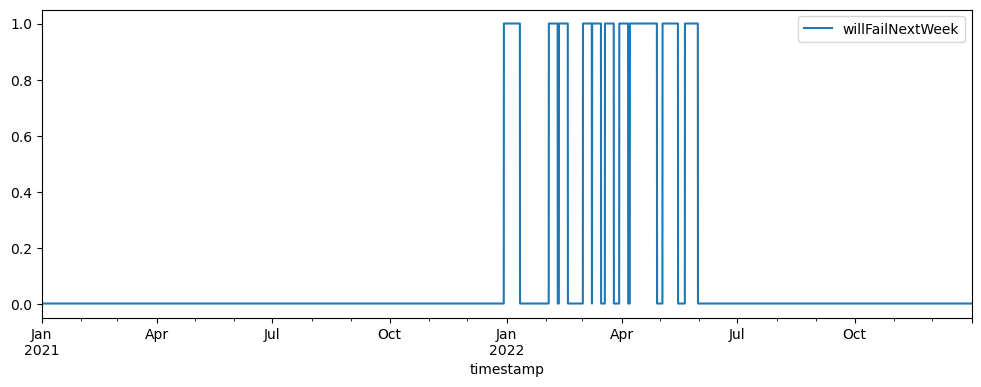

In [45]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(12,4))
plot_df = eval_fs_result.to_pandas()
for col in ['willFailNextWeek']:
    plot_df.plot(x='timestamp', y=col, ax = ax)